In [ ]:
from zipfile import ZipFile

In [ ]:
file_name1 = '/content/rumoureval-2019-test-data.zip'

with ZipFile(file_name1) as zip1:
  zip1.extractall()
  print('Done')

file_name2 = '/content/rumoureval-2019-training-data.zip'

with ZipFile(file_name2) as zip2:
  zip2.extractall()
  print('Done')

Done
Done


In [ ]:
import json
import math
from os import listdir
import sys
import re
import gensim
import requests
from collections import Counter

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential   
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# load word embedding trained from Tweetdata and Generaldata
emb = gensim.models.KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/Colab Notebooks/rumoureval2019 - LSTM/Set8_TweetDataWithoutSpam_GeneralData_Word_Phrase.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# make source tweets' ID a list for train, development and test data
trainFile = '/content/rumoureval-2019-training-data/train-key.json'
f = json.load(open(trainFile, 'r'))
trainSourceTweet = list(f['subtaskbenglish'].keys())  ######################
trainLabels = f['subtaskbenglish']

devFile = '/content/rumoureval-2019-training-data/dev-key.json'
f = json.load(open(devFile, 'r'))
devSourceTweet = list(f['subtaskbenglish'].keys())   ######################
devLabels = f['subtaskbenglish']

testFile = '/content/final-eval-key.json'
f = json.load(open(testFile, 'r'))
testSourceTweet = list(f['subtaskbenglish'].keys())  ######################
testLabels = f['subtaskbenglish']

In [ ]:
trainDocPath = '/content/rumoureval-2019-training-data/twitter-english'
trainDocList = listdir(trainDocPath)  # each element in doclist is a topic ['charliehebdo','ferguson'...]
devDocPath = trainDocPath # dev and train dataset are in the same directory
devDocList = trainDocList

testDocPath = '/content/rumoureval-2019-test-data/twitter-en-test-data'
testDocList = listdir(testDocPath)

In [ ]:
trainDocList

['illary',
 'sydneysiege',
 'prince-toronto',
 'ebola-essien',
 'putinmissing',
 'ferguson',
 'ottawashooting',
 'charliehebdo',
 'germanwings-crash']

In [ ]:
def getStructure(sourceTweets,filePath):
#@@ Param:  
#Source_tweets: a list of source tweets ID
#filePath: source tweets  parent document directory
#@@ Return: 
#structures:an tree stucture , each root is a source tweet ID, values are tweets replying to the parent node
    
    structures ={}
    docs = listdir(filePath)
    
    for tweetID in sourceTweets:
        for i in range(len(docs)):
            IDs = listdir(filePath+'/'+docs[i])
            if tweetID in IDs:
                tmp = json.load(open(filePath+'/'+docs[i]+'/'+tweetID+'/structure.json','r'))
                structures[tweetID] = tmp[tweetID]
               
    return structures

In [ ]:
trainStructure = getStructure(trainSourceTweet ,trainDocPath)  # length: 297
devStructure = getStructure(devSourceTweet ,devDocPath) # length: 28
testStructure = getStructure(testSourceTweet ,testDocPath) # length: 56

In [ ]:
def extractFeatures(filePath, featureList):
#@@ Param:  
# filePath:  tweets  parent document directory
# featureList: a list of features need extracting from .json, in which element should be consistent with field name in .json 
#@@ Return: 
# tweetTEUE: an dictionary, which the key: Values is tweetID : 'text'， including source tweets and reply tweets
    
    tweetTEUE = {}
    docs = listdir(filePath)
    
    for i in range(len(docs)):
        IDs = listdir(filePath+'/'+docs[i])
        for tweetID in IDs:
            tweetTEUE[tweetID] = {feature:[] for feature in featureList}
            sourceTemp = json.load(open(filePath+'/'+docs[i]+'/'+tweetID+'/source-tweet/'+tweetID+'.json','r'))
            tweetTEUE[tweetID]['text'] = sourceTemp['text']
            for j in range(1,len(featureList)): ################################# modify the n in ''range(n, len(featureList))''
                tweetTEUE[tweetID][featureList[j]] = sourceTemp['user'][featureList[j]]
            
            replyIDs = listdir(filePath+'/'+docs[i]+'/'+tweetID+'/replies')
            replyIDs = [jsonFile.replace('.json','') for jsonFile in replyIDs]
            for ID in replyIDs:
                tweetTEUE[ID] = {feature:[] for feature in featureList}
                replyTemp = json.load(open(filePath+'/'+docs[i]+'/'+tweetID+'/replies/'+ID+'.json','r'))
                tweetTEUE[ID]['text'] = replyTemp['text']
                for k in range(1,len(featureList)): ############################ modify the n in ''range(n, len(featureList))''
                    tweetTEUE[ID][featureList[k]] = replyTemp['user'][featureList[k]]

    return tweetTEUE

Json file explanation for twitter: https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object

In [ ]:
features = ['text', 'name','verified', 'location', 'description', 'followers_count',
                                  'friends_count', 'statuses_count', 'created_at']


tweetID2Features = extractFeatures(trainDocPath,features)

testFeatures = extractFeatures(testDocPath,features)

In [ ]:
tweetID2Features

In [ ]:
def getSourceText(structure, featureList): # get texts and respoding ID from source tweets
    
    sourceText = []
    ID = []
    for sourceID in structure:
        sourceText += [featureList[sourceID]['text']]
        ID += [sourceID]
        
    return sourceText,ID       

In [ ]:
trainSourceText, trainID = getSourceText(trainStructure, tweetID2Features) ######################################
devSourceText, devID = getSourceText(devStructure, tweetID2Features) #################################
testSourceText, testID = getSourceText(testStructure, testFeatures) ######################################

In [ ]:
print(len(trainSourceText))

297


In [ ]:
textList = [] ############################ these texts are from train and dev sets (including source texts and its' replies)
for t in list(tweetID2Features.keys()):
    textList += [tweetID2Features[t]['text']]

In [ ]:
len(textList)

5568

In [ ]:
def extractNgrams(x_raw, ngram_range=(1,3), token_pattern='[@#]*[A-Za-z0-9_-]+', stop_words=[], vocab=set()): # this function calls GATE API 
    
#@@ Param:
# x_raw: a string corresponding to the raw text of a document
# ngram_range: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
# token_pattern: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
# stop_words: a list of stop words
# vocab: a given vocabulary. It should be used to extract specific features.

#@@Returns:
# x:a list of all extracted word tokens.
    
    # requests api
    payload = {'text':x_raw}
    r = requests.post('https://cloud-api.gate.ac.uk/process-document/twitie-named-entity-recognizer-for-tweets?annotations=:URL,:UserID,:Date',
                      json=payload, auth=('gc22ns8ovnuz', '1vdoc3k7m35cc1tkibvt'))
    
    r = json.loads(r.text)
    
    # convert years and dates into symbols
    if 'Date' in r['entities']:
        dateList = [] # store the string
        symbolList = [] # symbols of year/date, same length with dateList
        for i in range(len(r['entities']['Date'])):
            if r['entities']['Date'][i]['ruleFinal'] == 'YearOnlyFinal':
                index1,index2 = r['entities']['Date'][i]['indices'] 
                date = r['text'][index1:index2]
                dateList += [date]
                symbolList += ['$year']        
            if r['entities']['Date'][i]['ruleFinal'] == 'DateOnlyFinal':
                index1,index2 = r['entities']['Date'][i]['indices'] 
                date = r['text'][index1:index2]
                dateList += [date]
                symbolList += ['$date']
        for i in range(len(dateList)):
            r['text'] = r['text'].replace(dateList[i],symbolList[i])
        
                
    # remove URL, mentions
    if 'URL' in r['entities']:
        for i in range(len(r['entities']['URL'])):
            remove = r['entities']['URL'][i]['string']
            r['text'] = r['text'].replace(remove,'')
    
    if 'UserID' in r['entities']:
        for i in range(len(r['entities']['UserID'])):
            remove = '@'+ r['entities']['UserID'][i]['string']
            r['text'] = r['text'].replace(remove,'')
            
    
    x_raw = r['text']
    unigram = re.compile(token_pattern,re.I).findall(x_raw)#tokenise
    
    # convert words to lowercase
    for i in range(len(unigram)):
        unigram[i] = unigram[i].lower()   
    
    word_list = []
    for i in range(len(unigram)):
        numList = re.compile('[0-9]+',re.I).findall(unigram[i])
        if len(numList) == 0:
            word_list += [unigram[i]]
        else:
            for j in range(len(numList)):
              unigram[i] = unigram[i].replace(numList[j],'$number')
            word_list += [unigram[i]]
       
            
       
    #create ngram lists according to ngram_range
    ngram_range_list = list(range(ngram_range[0],ngram_range[1]+1))  
    x_temp=[]
    for j in ngram_range_list:
        if j==1:
            for i in range(0,len(word_list)):
                x_temp.append(word_list[i])       
        if j>1:
            for i in range(0,len(word_list)):
                if i+j <= len(word_list):
                    x_temp.append(tuple(word_list[i:i+j]))
                
    #output final result x according to vocab
    x=[]
    if vocab == set():#by default, vocab==set(),in this case, word list don't need to be processed
        x=x_temp
    else:
        vocab = list(vocab)#if given a list of vocabulary, function should return the words needed
        for element in x_temp:
            if element in vocab:
                x.append(element)

    
    return x

In [ ]:
def getVocab(X_raw, ngram_range=(1,3), token_pattern='[@#]*[A-Za-z0-9_-]+', 
              min_df=0, keep_topN=0, stop_words=[]):
    
    #create lists for counting document frequency and collection frequency
    lists_df=[] 
    lists_cf=[]
    for x_raw in X_raw:
        temp_cf = extractNgrams(x_raw, ngram_range,token_pattern)
        temp_df = list(set(temp_cf)) #remove repeat element in each document for counting document frequency
        lists_cf += temp_cf
        lists_df += temp_df
    
    #count document frequency
    df = Counter()
    for ngram in lists_df:
        df[ngram] += 1
    if min_df != 0:
        df = {k:v for k,v in df.items() if v>=min_df}
        df = sorted(df.items(),key=lambda x:x[1],reverse=True)
        df = Counter(dict(df))
    
    #count collection frequency    
    cf = Counter()
    for ngram in lists_cf:
        cf[ngram] += 1
    ngram_counts = cf #ngram_counts is the collection frequency
    
    #get vocab according to keep_topN
    if keep_topN != 0:
        tmp = {k:v for k,v in ngram_counts.items()}
        tmp = sorted(tmp,key=lambda x:tmp[x],reverse=True)
        vocab = tmp[:keep_topN]
        vocab = set(vocab)
    else:
        vocab = set(lists_df)
    
    return vocab, df, ngram_counts

# GATE NER API

endpoint = 'https://cloud-api.gate.ac.uk/process-document/twitie-named-entity-recognizer-for-tweets?annotations=:URL,:UserID,:Date'

keyID = 'gc22ns8ovnuz'

password = '1vdoc3k7m35cc1tkibvt'

In [ ]:
vocab_tr, df_tr, ngram_counts_tr = getVocab(trainSourceText,ngram_range=(1,1))
vocab_dev, df_dev, ngram_counts_dev = getVocab(devSourceText,ngram_range=(1,1))
vocab_te, df_te, ngram_counts_te = getVocab(testSourceText,ngram_range=(1,1))

In [ ]:
vocab_tmp = vocab_tr.union(vocab_dev,vocab_te)

In [ ]:
len(vocab_tmp)

1633

In [ ]:
vocab = set()
for word in vocab_tmp:
    if word in emb:
        vocab.add(word)
len(vocab)

1573

In [ ]:
word2id={}
count = 1
for wrd in vocab:
    word2id[wrd] = count
    count += 1

In [ ]:
word2id['<OOV>'] = len(word2id)+1 # out of vocab

In [ ]:
id2word = dict([val, key] for key, val in word2id.items()) ##############################################

In [ ]:
s = str(word2id)
f = open('dict.txt','w')
f.writelines(s)
f.close()

In [ ]:
f = open('dict.txt','r')
f = f.read()
word2id = eval(f) ###############################

In [ ]:
id2word = dict([val, key] for key, val in word2id.items()) ##############################################

In [ ]:
len(word2id)

1574

In [ ]:
print(len(vocab))
print()
print(list(vocab_tr)[:100])
print()
print(df_tr.most_common()[:10])

1573

['amid', 'original', 'both', 'so', 'northern', 'high-risk', 'cartoon', 'fled', 'harassment', 'dozen', 'market', 'rcmp', 'maintain', 'andr', 'live', 'id', 'background', 'link', 'martial', 'lobby', 'citizens', 'mayday', 'let', 'looting', 'level', 'shooting', 'seem', 'detain', 'union', 'borne', 'rideau', 'summer', 'killer', 'deck', 'situations', 'dies', 'hand', 'from', 'source', 'her', 'radio', 'sniper', 'attackers', '#abbott', 'al', 'c', 'times', 'when', 'tell', 'downtown', 'ppl', 'guard', 'everyone', 'able', 'killed', 'hughes', 'clothing', 'seeking', 'member', 'w', 'list', '#prayforsydney', 'winkelmann', 'staff', 'kill', 'die', 'house', 'caught', 'inquiries', 'massey', 'earlier', 'over', 'chief', 'hell', 'deliver', 'protests', 'lack', 'aviation', 'accident', 'celebrities', 'age', '#abcnews$number', '$numbernews', 'one', 'r', 'reservist', 'in$number', 'suggesting', '#$numbernews', 'formal', 'a$number', 've', 'harper', 'people', 'watch', 'morning', 'rick', '#mikebrown', 'chocolate',

In [ ]:
payload = {'text': 'France: 10 people dead after shooting at HQ of satirical weekly newspaper #CharlieHebdo, according to witnesses http://t.co/FkYxGmuS58'}

r = requests.post('https://cloud-api.gate.ac.uk/process-document/twitie-named-entity-recognizer-for-tweets?annotations=:URL,:UserID,:Date',
                      json=payload)
    
r = json.loads(r.text)
r

{'entities': {'URL': [{'category': 'URL',
    'indices': [112, 134],
    'kind': 'URL',
    'length': 22,
    'replaced': 10,
    'rule': 'URL',
    'string': 'http://t.co/FkYxGmuS58'}]},
 'text': 'France: 10 people dead after shooting at HQ of satirical weekly newspaper #CharlieHebdo, according to witnesses http://t.co/FkYxGmuS58'}

In [ ]:
asd = 'She is a 2-3 and 3-year-old at 7pm and 23rd'
extractNgrams(asd,ngram_range=(1,1))

['she',
 'is',
 'a',
 '$number-$number',
 'and',
 '$number-year-old',
 'at',
 '$numberpm',
 'and',
 '$numberrd']

In [ ]:
################ using pre-trained word embedding 
X_tr = [extractNgrams(x, ngram_range=(1, 1)) for x in trainSourceText] ###############################
X_dev = [extractNgrams(x,ngram_range=(1,1)) for x in devSourceText ] ################################
X_te = [extractNgrams(x,ngram_range=(1,1)) for x in testSourceText ] ################################

In [ ]:
X_tr[0]

['did',
 'anyone',
 'think',
 'of',
 'comparing',
 'the',
 'clothes',
 'that',
 '#mikebrown',
 'was',
 'wearing',
 'when',
 'he',
 'was',
 'laying',
 'on',
 'the',
 'street',
 'to',
 'the',
 'security',
 'footage',
 '#ferguson']

In [ ]:
def writeFile(file_name,X_ngrams):

  f = open(file_name,'w')
  for text in X_ngrams:
    for wrd in text:
      f.write(wrd)
      f.write(' ')
    f.write('\n')
  
  return 0

In [ ]:
writeFile('X_tr_string.txt',X_tr)
writeFile('X_dev_string.txt',X_dev)
writeFile('X_te_string.txt',X_te)


In [ ]:
def readFile(filePath):

  with open(filePath,'r') as f:
    s = f.readlines()
  
  for i in range(len(s)):
    s[i] = s[i].replace('\n','')

  return s

In [ ]:
X_tr_string = readFile('X_tr_string.txt')
X_dev_string = readFile('X_dev_string.txt')
X_te_string = readFile('X_te_string.txt')

In [ ]:
X_tr_string ############################### text data after data washing

In [ ]:
def tokenizeText(x_raw):

  x = x_raw.split(' ')
  x.remove('')

  return x

In [ ]:
X_tr = [tokenizeText(x) for x in X_tr_string] ###############################
X_dev = [tokenizeText(x) for x in X_dev_string] ################################ into token
X_te = [tokenizeText(x) for x in X_te_string] ################################

In [ ]:
def toNumSeq(X_raw,vocab):
  
  doc = []
  
  for text in X_raw:
    numSeq = []
    for wrd in text:
      if wrd in vocab:
        numSeq += [vocab[wrd]]
      else:
        numSeq += [vocab['<OOV>']]
    doc += [numSeq]
  
  return doc


In [ ]:
X_tr_seq = toNumSeq(X_tr,word2id) #############
X_dev_seq = toNumSeq(X_dev,word2id)############## num of sequence
X_te_seq = toNumSeq(X_te,word2id)###############

In [ ]:
print(X_tr[100])
print(word2id['prime'])
print(word2id['minister'])

['prime', 'minister', 'tony', 'abbott', 's', 'statement', 'on', 'the', '#sydneysiege', 'updates']
438
404


In [ ]:
X_tr_seq[100]

[438, 404, 617, 1425, 1442, 200, 319, 511, 134, 1066]

In [ ]:
X_tr_paded = pad_sequences(X_tr_seq,padding="pre") ################################################
X_dev_paded = pad_sequences(X_dev_seq,maxlen=len(X_tr_paded[0]),padding="pre")############################################### zero padding
X_te_paded = pad_sequences(X_te_seq,maxlen=len(X_tr_paded[0]),padding="pre")##############################################

In [ ]:
print(X_tr_paded[0])
print(X_dev_paded[0])

[   0    0    0    0    0  648 1415  163 1274  619  511 1509  697  806
 1078 1406 1193   91 1078  204  319  511  740 1375  511  600 1521  450]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0  693 1283  774  163 1417 1111  937 1187]


In [ ]:
################################################## prepare embedding matrix for embedding layer

embedding_matrix = np.zeros((len(word2id)+1,300))
for word, i in word2id.items():
  if word in emb:
    embedding_vector = emb[word]
    embedding_matrix[i] = embedding_vector
  else:
    embedding_matrix[i] = np.zeros(300)


In [ ]:
#transfer label
def str2no(y_string):
#@@ Param: a list of rumour veracity labels, each element is a string
#@@ Return: a list of label, each element is an int; 0,1,2 represent 'unverified','false','true' respectively
    
    y = []
    for cls in y_string:
        if cls=='unverified':
            y += [0]
        elif cls=='false':
            y += [1]
        elif cls=='true':
            y += [2]
    return y

In [ ]:
Y_tr = [trainLabels[ID] for ID in trainID]
Y_dev = [devLabels[ID] for ID in devID] 

In [ ]:
Y_tr = str2no(Y_tr) ########################################
Y_dev = str2no(Y_dev) ######################################  Y_input

In [ ]:
print(X_tr_paded)

[[   0    0    0 ...  600 1521  450]
 [   0    0    0 ...  522  119  450]
 [   0    0    0 ... 1256 1333  951]
 ...
 [   0    0    0 ... 1574  227 1017]
 [   0    0    0 ...   80  511 1241]
 [   0    0    0 ... 1073  252  503]]


In [ ]:
def num2onehot(Y):
  
  onehot = []
  for num in Y:
    if num==0:
      onehot += [[1,0,0]]
    if num==1:
      onehot += [[0,1,0]]
    if num==2:
      onehot += [[0,0,1]] 
  
  return onehot

In [ ]:
Y_tr = num2onehot(Y_tr)
Y_dev = num2onehot(Y_dev)


In [ ]:
Y_tr = np.array(Y_tr)  ###################################
Y_dev = np.array(Y_dev) ####################################

In [ ]:
X_tr_paded = np.array(X_tr_paded)
X_dev_paded = np.array(X_dev_paded)

In [ ]:
def build_model(): ########### simple LSTM
    
    model = Sequential([
    layers.Embedding(len(embedding_matrix), 300,  
            mask_zero=True, 
            embeddings_initializer=initializers.Constant(embedding_matrix),
            input_length=len(X_tr_paded[0]), 
            trainable=False),
    layers.Dropout(0.2),
    layers.LSTM(300,return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(3,activation='softmax')
    ])

    model.compile(optimizer=optimizers.Adam(lr=0.01),loss='categorical_crossentropy',metrics=['acc'])
    print(model.summary())

    return model

model = build_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 28, 300)           472500    
_________________________________________________________________
dropout (Dropout)            (None, 28, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 903       
Total params: 1,194,603
Trainable params: 722,103
Non-trainable params: 472,500
_________________________________________________________________
None


In [ ]:
history = model.fit(x=X_tr_paded, y=Y_tr, batch_size=297, epochs=50, validation_data=(X_dev_paded,Y_dev),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=0, min_delta=0.00001)])

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 1.0986 - acc: 0.3401 - val_loss: 4.0372 - val_acc: 0.2857
Epoch 2/50
1/1 [==============================] - 0s 57ms/step - loss: 2.5017 - acc: 0.4781 - val_loss: 1.4519 - val_acc: 0.2857
Epoch 3/50
1/1 [==============================] - 0s 54ms/step - loss: 1.4098 - acc: 0.3603 - val_loss: 1.2045 - val_acc: 0.5357
Epoch 4/50
1/1 [==============================] - 0s 54ms/step - loss: 1.5210 - acc: 0.3872 - val_loss: 1.1613 - val_acc: 0.3929
Epoch 5/50
1/1 [==============================] - 0s 58ms/step - loss: 1.0007 - acc: 0.5286 - val_loss: 1.2875 - val_acc: 0.3929


In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()



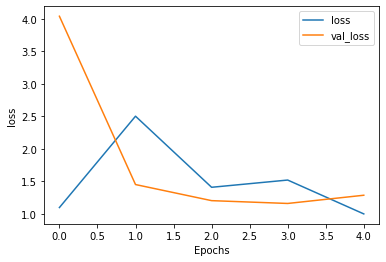

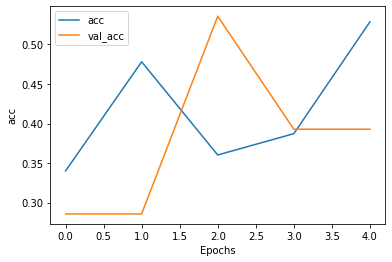

In [ ]:
plot_graphs(history, 'loss')
plot_graphs(history, 'acc')


In [ ]:
sig_clf_probs = model.predict_proba(X_te_paded) 

y_hat = model.predict_classes(X_te_paded) ######################### predicted label as 3 classes

Instructions for updating:
Please use `model.predict()` instead.
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
y_hat

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0,
       2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0])

In [ ]:
clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

for i in range(len(y_hat)):
  if y_hat[i]!=0:
    clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
  else:
    if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
      clf_confidence[i] = sig_clf_probs[i][1]
      y_hat[i] = 1
    else:
      clf_confidence[i] = sig_clf_probs[i][2]
      y_hat[i] = 2
            


In [ ]:
y_hat

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
def scorer(y_truth, y_hat, confidence): # rumourEval 2019 version of scorer
#@ Param:  y_truth: a list of true labels
#          y_hat: a list of predicted y values
#          confidence: a list of confidence values related to y_hat
# Return: accuracy score, RMSE and Macro averaged F1 score
    
    correct = 0
    total = len(y_hat)
    errors = []
    y_pred = []
    
    for i in range(total):
        if confidence[i]>0.5:
                y_pred += [y_hat[i]]
        else:
                y_pred += [0]   
        
        if y_pred[i] == y_truth[i] and y_truth[i]!=0:
            correct += 1
            errors += [(1-confidence[i])**2]

        elif y_truth[i] == 0:
            errors += [ (confidence[i])**2 ]

        else:
            errors += [1.0]
    
    score = correct / total
    rmse = math.sqrt( sum(errors) / len(errors) )
    macroF = f1_score(y_truth, y_pred, average='macro')

    return score,rmse,macroF

In [ ]:
Y_te = [testLabels[ID] for ID in testID] ####################################
Y_te = str2no(Y_te) #########################################

In [ ]:
score,rmse,macroF = scorer(Y_te,y_hat,clf_confidence) # F-score is ill-defined and being set to 0.0 in labels with no predicted samples
print('accuracy:', score)
print('RMSE:', rmse)
print('Macro averaged F1 socre:', macroF)

accuracy: 0.0
RMSE: 0.9757452611390581
Macro averaged F1 socre: 0.02380952380952381


In [ ]:
def build_model(): ################# bidirectional LSTM
    
    model = Sequential([
    layers.Embedding(len(embedding_matrix), 300,  
            mask_zero=True, 
            embeddings_initializer=initializers.Constant(embedding_matrix),
            input_length=len(X_tr_paded[0]), 
            trainable=False),
    layers.Dropout(0.1),
    layers.Bidirectional(layers.LSTM(300,return_sequences=False)),
    layers.Dropout(0.1),
    layers.Dense(3,activation='softmax')
    ])

    model.compile(optimizer=optimizers.Adam(lr=0.01),loss='categorical_crossentropy',metrics=['acc'])
    print(model.summary())

    return model

model = build_model()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 28, 300)           472500    
_________________________________________________________________
dropout_22 (Dropout)         (None, 28, 300)           0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 600)               1442400   
_________________________________________________________________
dropout_23 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 1803      
Total params: 1,916,703
Trainable params: 1,444,203
Non-trainable params: 472,500
_________________________________________________________________
None


In [ ]:
history = model.fit(x=X_tr_paded, y=Y_tr, batch_size=297, epochs=25, validation_data=(X_dev_paded,Y_dev))
                    #callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.000001)])

Epoch 1/25
1/1 [==============================] - 2s 2s/step - loss: 1.0975 - acc: 0.3535 - val_loss: 7.4964 - val_acc: 0.2857
Epoch 2/25
1/1 [==============================] - 0s 51ms/step - loss: 5.1541 - acc: 0.4613 - val_loss: 1.7019 - val_acc: 0.2500
Epoch 3/25
1/1 [==============================] - 0s 42ms/step - loss: 1.5425 - acc: 0.3569 - val_loss: 1.7995 - val_acc: 0.4286
Epoch 4/25
1/1 [==============================] - 0s 35ms/step - loss: 2.2399 - acc: 0.2189 - val_loss: 1.4213 - val_acc: 0.3571
Epoch 5/25
1/1 [==============================] - 0s 37ms/step - loss: 1.0517 - acc: 0.5354 - val_loss: 1.4728 - val_acc: 0.3929
Epoch 6/25
1/1 [==============================] - 0s 33ms/step - loss: 0.9560 - acc: 0.6128 - val_loss: 1.3941 - val_acc: 0.3214
Epoch 7/25
1/1 [==============================] - 0s 37ms/step - loss: 0.9832 - acc: 0.5017 - val_loss: 1.1228 - val_acc: 0.3929
Epoch 8/25
1/1 [==============================] - 0s 40ms/step - loss: 0.8665 - acc: 0.5690 - val_l

In [ ]:
print(history)

In [ ]:
history.on_epoch_end

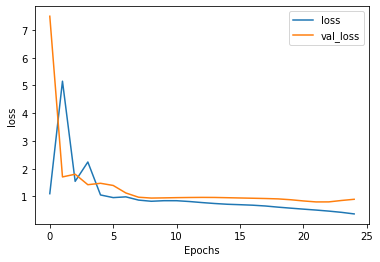

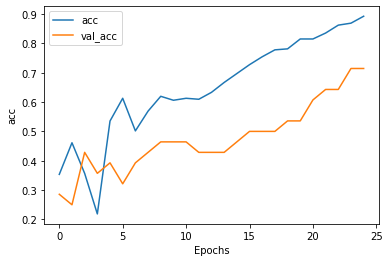

In [ ]:
plot_graphs(history, 'loss')
plot_graphs(history, 'acc')


In [ ]:
sig_clf_probs = model.predict(X_te_paded) 

y_hat = model.predict_classes(X_te_paded) ######################### predicted label as 3 classes


In [ ]:
y_hat ################# this y_hat was generated from model

array([0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 1, 1, 2, 0, 0, 0, 1, 1, 0, 1, 0, 2,
       2, 1, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 2, 1, 2, 0, 2, 2, 2, 0, 2, 2, 1])

In [ ]:
clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

for i in range(len(y_hat)):
  if y_hat[i]!=0:
    clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
  else:
    if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
      clf_confidence[i] = sig_clf_probs[i][1]
      y_hat[i] = 1
    else:
      clf_confidence[i] = sig_clf_probs[i][2]
      y_hat[i] = 2

In [ ]:
print(Y_te)

[2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2]


In [ ]:
y_hat ####################### this y_hat was modified according to rules

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1])

In [ ]:
score,rmse,macroF = scorer(Y_te,y_hat,clf_confidence) # F-score is ill-defined and being set to 0.0 in labels with no predicted samples
print('accuracy:', score)
print('RMSE:', rmse)
print('Macro averaged F1 socre:', macroF)

accuracy: 0.2857142857142857
RMSE: 0.8289270864114356
Macro averaged F1 socre: 0.3439660590823381


In [ ]:
import tensorflow.keras.callbacks as cb
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [ ]:
def build_model(): ################# bidirectional LSTM
    
    model = Sequential([
    layers.Embedding(len(embedding_matrix), 300,  
            mask_zero=True, 
            embeddings_initializer=initializers.Constant(embedding_matrix),
            input_length=len(X_tr_paded[0]), 
            trainable=False),
    layers.Dropout(0.1),
    layers.Bidirectional(layers.LSTM(300,return_sequences=False)),
    layers.Dropout(0.1),
    layers.Dense(3,activation='softmax')
    ])

    model.compile(optimizer=optimizers.Adam(lr=0.01),loss='categorical_crossentropy',metrics=['acc'])
    print(model.summary())

    return model

model = build_model()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 28, 300)           472500    
_________________________________________________________________
dropout_28 (Dropout)         (None, 28, 300)           0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 600)               1442400   
_________________________________________________________________
dropout_29 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 1803      
Total params: 1,916,703
Trainable params: 1,444,203
Non-trainable params: 472,500
_________________________________________________________________
None


In [ ]:
myLossHistory = LossHistory()
history = model.fit(x=X_tr_paded, y=Y_tr, batch_size=297, epochs=25, validation_data=(X_dev_paded,Y_dev)
                    ,callbacks=[myLossHistory])

Epoch 1/25
1/1 [==============================] - 2s 2s/step - loss: 1.0840 - acc: 0.4242 - val_loss: 6.1953 - val_acc: 0.2857
Epoch 2/25
1/1 [==============================] - 0s 37ms/step - loss: 3.8754 - acc: 0.4613 - val_loss: 2.5567 - val_acc: 0.2857
Epoch 3/25
1/1 [==============================] - 0s 31ms/step - loss: 2.6250 - acc: 0.3333 - val_loss: 1.4955 - val_acc: 0.4643
Epoch 4/25
1/1 [==============================] - 0s 32ms/step - loss: 1.8395 - acc: 0.2862 - val_loss: 1.4402 - val_acc: 0.3929
Epoch 5/25
1/1 [==============================] - 0s 32ms/step - loss: 1.1290 - acc: 0.5488 - val_loss: 1.4842 - val_acc: 0.3571
Epoch 6/25
1/1 [==============================] - 0s 38ms/step - loss: 0.9785 - acc: 0.6027 - val_loss: 1.4204 - val_acc: 0.3214
Epoch 7/25
1/1 [==============================] - 0s 36ms/step - loss: 1.0108 - acc: 0.4646 - val_loss: 1.1377 - val_acc: 0.3929
Epoch 8/25
1/1 [==============================] - 0s 50ms/step - loss: 0.8541 - acc: 0.6229 - val_l

In [ ]:
bilstm_loss = myLossHistory.val_loss['epoch'] ##########################

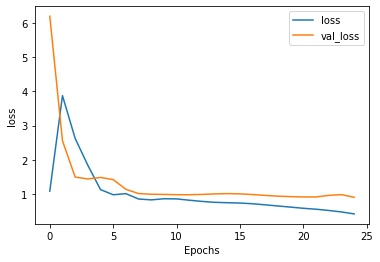

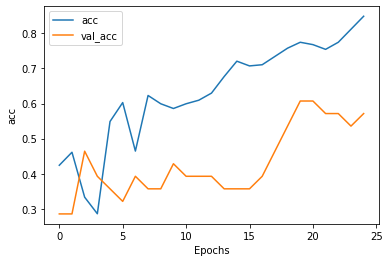

In [ ]:
plot_graphs(history, 'loss')
plot_graphs(history, 'acc')


In [ ]:
def build_model(): ################# 2 layers bidirectional LSTM
    
    model = Sequential([
    layers.Embedding(len(embedding_matrix), 300,  
            mask_zero=True, 
            embeddings_initializer=initializers.Constant(embedding_matrix),
            input_length=len(X_tr_paded[0]), 
            trainable=False),
    layers.Dropout(0.1),
    layers.Bidirectional(layers.LSTM(300,return_sequences=True)),
    layers.Bidirectional(layers.LSTM(300,return_sequences=False)),
    layers.Dropout(0.1),
    layers.Dense(3,activation='softmax')
    ])

    model.compile(optimizer=optimizers.Adam(lr=0.01),loss='categorical_crossentropy',metrics=['acc'])
    print(model.summary())

    return model

model = build_model()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 28, 300)           472500    
_________________________________________________________________
dropout_48 (Dropout)         (None, 28, 300)           0         
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 28, 600)           1442400   
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 600)               2162400   
_________________________________________________________________
dropout_49 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 1803      
Total params: 4,079,103
Trainable params: 3,606,603
Non-trainable params: 472,500
_____________________________________

In [ ]:
myLossHistory = LossHistory()
history = model.fit(x=X_tr_paded, y=Y_tr, batch_size=297, epochs=50, validation_data=(X_dev_paded,Y_dev)
                    ,callbacks=[myLossHistory])

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 1.0889 - acc: 0.4444 - val_loss: 7.9082 - val_acc: 0.2857
Epoch 2/50
1/1 [==============================] - 0s 48ms/step - loss: 4.6448 - acc: 0.4613 - val_loss: 5.2464 - val_acc: 0.2857
Epoch 3/50
1/1 [==============================] - 0s 46ms/step - loss: 6.0314 - acc: 0.3333 - val_loss: 5.5414 - val_acc: 0.4286
Epoch 4/50
1/1 [==============================] - 0s 50ms/step - loss: 7.4638 - acc: 0.2088 - val_loss: 3.8365 - val_acc: 0.2857
Epoch 5/50
1/1 [==============================] - 0s 49ms/step - loss: 3.1813 - acc: 0.4613 - val_loss: 2.5395 - val_acc: 0.3929
Epoch 6/50
1/1 [==============================] - 0s 47ms/step - loss: 3.6072 - acc: 0.3232 - val_loss: 2.4518 - val_acc: 0.2857
Epoch 7/50
1/1 [==============================] - 0s 50ms/step - loss: 1.9106 - acc: 0.3569 - val_loss: 1.3574 - val_acc: 0.3214
Epoch 8/50
1/1 [==============================] - 0s 49ms/step - loss: 1.1879 - acc: 0.3838 - val_l

In [ ]:
bibilstm_loss = myLossHistory.val_loss['epoch'] ##########################

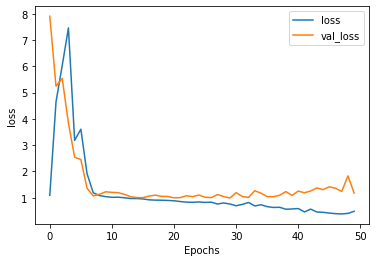

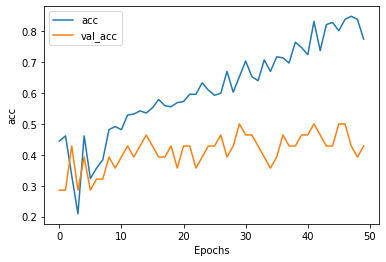

In [ ]:
plot_graphs(history, 'loss')
plot_graphs(history, 'acc')


In [ ]:
sig_clf_probs = model.predict(X_te_paded) ################# 2 layers bidirectional LSTM

y_hat = model.predict_classes(X_te_paded) ######################### predicted label as 3 classes

clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

for i in range(len(y_hat)):
  if y_hat[i]!=0:
    clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
  else:
    if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
      clf_confidence[i] = sig_clf_probs[i][1]
      y_hat[i] = 1
    else:
      clf_confidence[i] = sig_clf_probs[i][2]
      y_hat[i] = 2

score,rmse,macroF = scorer(Y_te,y_hat,clf_confidence) # F-score is ill-defined and being set to 0.0 in labels with no predicted samples
print('accuracy:', score)
print('RMSE:', rmse)
print('Macro averaged F1 socre:', macroF)

accuracy: 0.3392857142857143
RMSE: 0.8129211755518386
Macro averaged F1 socre: 0.25199362041467305


In [ ]:
def build_model(): ################# text CNN
    
    model = Sequential([
    layers.Embedding(len(embedding_matrix), 300,  
            mask_zero=True, 
            embeddings_initializer=initializers.Constant(embedding_matrix),
            input_length=len(X_tr_paded[0]), 
            trainable=False),
    layers.Conv1D(filters=200,
          kernel_size=3,
          padding='valid',
         activation='relu',
             strides=1),
    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.1),
    layers.Dense(3,activation='softmax')
    ])

    model.compile(optimizer=optimizers.Adam(lr=0.01),loss='categorical_crossentropy',metrics=['acc'])
    print(model.summary())

    return model

model = build_model()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 28, 300)           472500    
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 26, 200)           180200    
_________________________________________________________________
global_max_pooling1d_18 (Glo (None, 200)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 603       
Total params: 653,303
Trainable params: 180,803
Non-trainable params: 472,500
_________________________________________________________________
None


In [ ]:
myLossHistory = LossHistory()
history = model.fit(x=X_tr_paded, y=Y_tr, batch_size=297, epochs=10, validation_data=(X_dev_paded,Y_dev)
                    ,callbacks=[myLossHistory])

Epoch 1/10
1/1 [==============================] - 0s 49ms/step - loss: 0.2562 - acc: 0.9226 - val_loss: 1.2232 - val_acc: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 15ms/step - loss: 0.2446 - acc: 0.9293 - val_loss: 1.1506 - val_acc: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 15ms/step - loss: 0.2043 - acc: 0.9529 - val_loss: 1.0264 - val_acc: 0.4643
Epoch 4/10
1/1 [==============================] - 0s 15ms/step - loss: 0.1455 - acc: 0.9731 - val_loss: 1.0088 - val_acc: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 17ms/step - loss: 0.1490 - acc: 0.9731 - val_loss: 1.0304 - val_acc: 0.5357
Epoch 6/10
1/1 [==============================] - 0s 15ms/step - loss: 0.1378 - acc: 0.9764 - val_loss: 1.0356 - val_acc: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 15ms/step - loss: 0.1016 - acc: 0.9933 - val_loss: 1.0962 - val_acc: 0.5000
Epoch 8/10
1/1 [==============================] - 0s 15ms/step - loss: 0.0778 - acc: 0.9933 - val

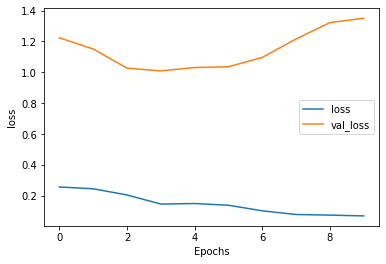

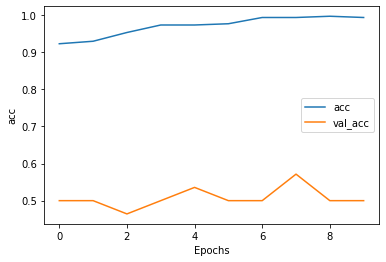

accuracy: 0.23214285714285715
RMSE: 0.866418572210853
Macro averaged F1 socre: 0.22238066943949297


In [ ]:
plot_graphs(history, 'loss')  ################# text CNN
plot_graphs(history, 'acc')

textCNN_loss = myLossHistory.val_loss['epoch'] ##########################

sig_clf_probs = model.predict(X_te_paded) 

y_hat = model.predict_classes(X_te_paded) ######################### predicted label as 3 classes

clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

for i in range(len(y_hat)):
  if y_hat[i]!=0:
    clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
  else:
    if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
      clf_confidence[i] = sig_clf_probs[i][1]
      y_hat[i] = 1
    else:
      clf_confidence[i] = sig_clf_probs[i][2]
      y_hat[i] = 2

score,rmse,macroF = scorer(Y_te,y_hat,clf_confidence) # F-score is ill-defined and being set to 0.0 in labels with no predicted samples
print('accuracy:', score)
print('RMSE:', rmse)
print('Macro averaged F1 socre:', macroF)

In [ ]:
from keras.layers import Layer
import keras.backend as K

def build(self,input_shape):
  self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
  self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
  super(attention, self).build(input_shape)

def call(self,x):
  et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
  at=K.softmax(et)
  at=K.expand_dims(at,axis=-1)
  output=x*at
  return K.sum(output,axis=1)

class attention(Layer):
  def __init__(self,**kwargs):
    super(attention,self).__init__(**kwargs)

  def build(self,input_shape):
    self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
    self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
    super(attention, self).build(input_shape)

  def call(self,x):
    et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
    at=K.softmax(et)
    at=K.expand_dims(at,axis=-1)
    output=x*at
    return K.sum(output,axis=1)

  def compute_output_shape(self,input_shape):
    return (input_shape[0],input_shape[-1])

  def get_config(self):
    return super(attention,self).get_config()

In [ ]:
from keras import Model

inputs=layers.Input(shape=(28,))
x=layers.Embedding(len(embedding_matrix), 300,  
            mask_zero=True, 
            embeddings_initializer=initializers.Constant(embedding_matrix),
            input_length=len(X_tr_paded[0]), 
            trainable=False)(inputs)
att_in=layers.LSTM(128,return_sequences=True,dropout=0.1,recurrent_dropout=0.2)(x)
att_out=attention()(att_in)
outputs=layers.Dense(3,activation='softmax')(att_out)
model=Model(inputs,outputs)
model.summary()

Model: "functional_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 28)]              0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 28, 300)           472500    
_________________________________________________________________
lstm_21 (LSTM)               (None, 28, 128)           219648    
_________________________________________________________________
attention_13 (attention)     (None, 128)               156       
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 387       
Total params: 692,691
Trainable params: 220,191
Non-trainable params: 472,500
_________________________________________________________________


In [ ]:
model.compile(optimizer=optimizers.Adam(lr=0.001),loss='categorical_crossentropy',metrics=['acc'])


In [ ]:

myLossHistory = LossHistory()
history = model.fit(x=X_tr_paded, y=Y_tr, batch_size=297, epochs=200, validation_data=(X_dev_paded,Y_dev),callbacks=[myLossHistory])

Epoch 1/200
1/1 [==============================] - 0s 52ms/step - loss: 0.7506 - acc: 0.6566 - val_loss: 1.0522 - val_acc: 0.4286
Epoch 2/200
1/1 [==============================] - 0s 29ms/step - loss: 0.7349 - acc: 0.6869 - val_loss: 1.0699 - val_acc: 0.4643
Epoch 3/200
1/1 [==============================] - 0s 30ms/step - loss: 0.7088 - acc: 0.7003 - val_loss: 1.0569 - val_acc: 0.4286
Epoch 4/200
1/1 [==============================] - 0s 31ms/step - loss: 0.6979 - acc: 0.7104 - val_loss: 1.1057 - val_acc: 0.4286
Epoch 5/200
1/1 [==============================] - 0s 28ms/step - loss: 0.6894 - acc: 0.7003 - val_loss: 1.1860 - val_acc: 0.4643
Epoch 6/200
1/1 [==============================] - 0s 31ms/step - loss: 0.6562 - acc: 0.7273 - val_loss: 1.2327 - val_acc: 0.4643
Epoch 7/200
1/1 [==============================] - 0s 27ms/step - loss: 0.6503 - acc: 0.7374 - val_loss: 1.1570 - val_acc: 0.3571
Epoch 8/200
1/1 [==============================] - 0s 28ms/step - loss: 0.6519 - acc: 0.73

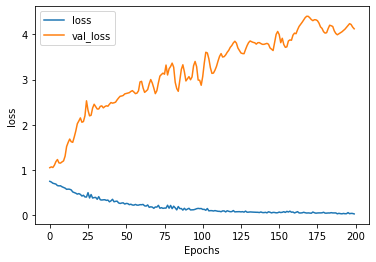

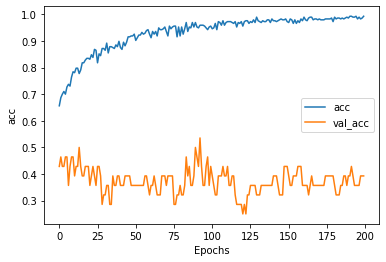

accuracy: 0.26785714285714285
RMSE: 0.8380038033258631
Macro averaged F1 socre: 0.2820061075875029


In [ ]:
plot_graphs(history, 'loss')  ################# text CNN
plot_graphs(history, 'acc')

attLSTM_loss = myLossHistory.val_loss['epoch'] ##########################

sig_clf_probs = model.predict(X_te_paded) 

y_hat = np.array([np.argmax(i) for i in sig_clf_probs]) ######################### predicted label as 3 classes

clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

for i in range(len(y_hat)):
  if y_hat[i]!=0:
    clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
  else:
    if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
      clf_confidence[i] = sig_clf_probs[i][1]
      y_hat[i] = 1
    else:
      clf_confidence[i] = sig_clf_probs[i][2]
      y_hat[i] = 2

score,rmse,macroF = scorer(Y_te,y_hat,clf_confidence) # F-score is ill-defined and being set to 0.0 in labels with no predicted samples
print('accuracy:', score)
print('RMSE:', rmse)
print('Macro averaged F1 socre:', macroF)

In [ ]:
def build_model(): ################# 2 layers bidirectional LSTM + attention
    
    model = Sequential()
    model.add(layers.Embedding(len(embedding_matrix), 300,  
            mask_zero=True, 
            embeddings_initializer=initializers.Constant(embedding_matrix),
            input_length=len(X_tr_paded[0]), 
            trainable=False))
    model.add(layers.Dropout(0.1))
    model.add(layers.Bidirectional(layers.LSTM(300,return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(300,return_sequences=True)))
    model.add(attention())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64))
    model.add(layers.Dense(3,activation='softmax'))
    

    model.compile(optimizer=optimizers.Adam(lr=0.01),loss='categorical_crossentropy',metrics=['acc'])
    print(model.summary())

    return model

model = build_model()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 28, 300)           472500    
_________________________________________________________________
dropout_11 (Dropout)         (None, 28, 300)           0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 28, 600)           1442400   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 28, 600)           2162400   
_________________________________________________________________
attention_24 (attention)     (None, 600)               628       
_________________________________________________________________
dropout_12 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)              

In [ ]:
myLossHistory = LossHistory()
history = model.fit(x=X_tr_paded, y=Y_tr, batch_size=297, epochs=200, validation_data=(X_dev_paded,Y_dev),callbacks=[myLossHistory])

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 1.0968 - acc: 0.3434 - val_loss: 5.1859 - val_acc: 0.2857
Epoch 2/200
1/1 [==============================] - 0s 48ms/step - loss: 3.2333 - acc: 0.4613 - val_loss: 1.1162 - val_acc: 0.5714
Epoch 3/200
1/1 [==============================] - 0s 47ms/step - loss: 1.2925 - acc: 0.3502 - val_loss: 9.5572 - val_acc: 0.2857
Epoch 4/200
1/1 [==============================] - 0s 46ms/step - loss: 6.2750 - acc: 0.4613 - val_loss: 8.5029 - val_acc: 0.2857
Epoch 5/200
1/1 [==============================] - 0s 49ms/step - loss: 7.5311 - acc: 0.3300 - val_loss: 1.5427 - val_acc: 0.4643
Epoch 6/200
1/1 [==============================] - 0s 48ms/step - loss: 2.4165 - acc: 0.2391 - val_loss: 1.8638 - val_acc: 0.4643
Epoch 7/200
1/1 [==============================] - 0s 47ms/step - loss: 2.2326 - acc: 0.2525 - val_loss: 1.0596 - val_acc: 0.3929
Epoch 8/200
1/1 [==============================] - 0s 47ms/step - loss: 1.1685 - acc: 0.3333

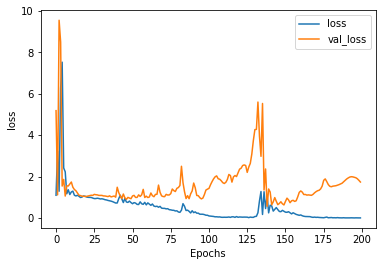

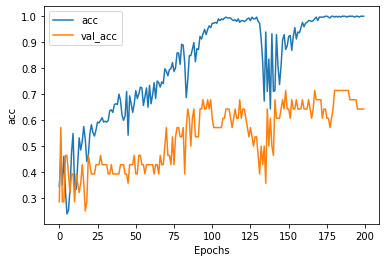

accuracy: 0.42857142857142855
RMSE: 0.7640488112842381
Macro averaged F1 socre: 0.315015015015015


In [ ]:
plot_graphs(history, 'loss')  ################# 2 Bilstm + attention
plot_graphs(history, 'acc')

att2BiLSTM_loss = myLossHistory.val_loss['epoch'] ##########################

sig_clf_probs = model.predict(X_te_paded) 

y_hat = np.array([np.argmax(i) for i in sig_clf_probs]) ######################### predicted label as 3 classes

clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

for i in range(len(y_hat)):
  if y_hat[i]!=0:
    clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
  else:
    if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
      clf_confidence[i] = sig_clf_probs[i][1]
      y_hat[i] = 1
    else:
      clf_confidence[i] = sig_clf_probs[i][2]
      y_hat[i] = 2

score,rmse,macroF = scorer(Y_te,y_hat,clf_confidence) # F-score is ill-defined and being set to 0.0 in labels with no predicted samples
print('accuracy:', score)
print('RMSE:', rmse)
print('Macro averaged F1 socre:', macroF)

In [ ]:
def build_model(): ################# single layers bidirectional LSTM + attention
    
    model = Sequential()
    model.add(layers.Embedding(len(embedding_matrix), 300,  
            mask_zero=True, 
            embeddings_initializer=initializers.Constant(embedding_matrix),
            input_length=len(X_tr_paded[0]), 
            trainable=False))
    model.add(layers.Bidirectional(layers.LSTM(300,return_sequences=True)))
    model.add(attention())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64))
    model.add(layers.Dense(3,activation='softmax'))
    

    model.compile(optimizer=optimizers.Adam(lr=0.01),loss='categorical_crossentropy',metrics=['acc'])
    print(model.summary())

    return model

model = build_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 300)           472500    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 28, 600)           1442400   
_________________________________________________________________
attention_1 (attention)      (None, 600)               628       
_________________________________________________________________
dropout_1 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                38464     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 1,954,187
Trainable params: 1,481,687
Non-trainable params: 472,500
______________________________________

In [ ]:
myLossHistory = LossHistory()
history = model.fit(x=X_tr_paded, y=Y_tr, batch_size=297, epochs=100, validation_data=(X_dev_paded,Y_dev),callbacks=[myLossHistory])

Epoch 1/100
1/1 [==============================] - 0s 53ms/step - loss: 0.6702 - acc: 0.7138 - val_loss: 1.2983 - val_acc: 0.2857
Epoch 2/100
1/1 [==============================] - 0s 35ms/step - loss: 0.6130 - acc: 0.7508 - val_loss: 1.2757 - val_acc: 0.4286
Epoch 3/100
1/1 [==============================] - 0s 33ms/step - loss: 0.5632 - acc: 0.7778 - val_loss: 1.4041 - val_acc: 0.4286
Epoch 4/100
1/1 [==============================] - 0s 32ms/step - loss: 0.5156 - acc: 0.8081 - val_loss: 1.3820 - val_acc: 0.3929
Epoch 5/100
1/1 [==============================] - 0s 32ms/step - loss: 0.4785 - acc: 0.7912 - val_loss: 1.9408 - val_acc: 0.3214
Epoch 6/100
1/1 [==============================] - 0s 31ms/step - loss: 0.4634 - acc: 0.7946 - val_loss: 1.4858 - val_acc: 0.4643
Epoch 7/100
1/1 [==============================] - 0s 30ms/step - loss: 0.5265 - acc: 0.7845 - val_loss: 1.9494 - val_acc: 0.3929
Epoch 8/100
1/1 [==============================] - 0s 32ms/step - loss: 0.4917 - acc: 0.76

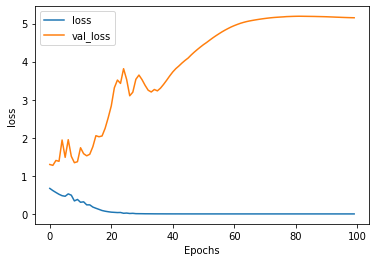

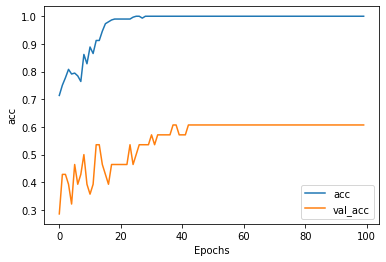

accuracy: 0.21428571428571427
RMSE: 0.865455907113214
Macro averaged F1 socre: 0.24245253657018365


In [ ]:
plot_graphs(history, 'loss')  ################# sigle bilstm + attention
plot_graphs(history, 'acc')

attSingleBiLSTM_loss = myLossHistory.val_loss['epoch'] ##########################

sig_clf_probs = model.predict(X_te_paded) 

y_hat = np.array([np.argmax(i) for i in sig_clf_probs]) ######################### predicted label as 3 classes

clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

for i in range(len(y_hat)):
  if y_hat[i]!=0:
    clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
  else:
    if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
      clf_confidence[i] = sig_clf_probs[i][1]
      y_hat[i] = 1
    else:
      clf_confidence[i] = sig_clf_probs[i][2]
      y_hat[i] = 2

score,rmse,macroF = scorer(Y_te,y_hat,clf_confidence) # F-score is ill-defined and being set to 0.0 in labels with no predicted samples
print('accuracy:', score)
print('RMSE:', rmse)
print('Macro averaged F1 socre:', macroF)

In [ ]:
def build_model(): ################# 2 layers bidirectional LSTM + attention
    
    model = Sequential()
    model.add(layers.Embedding(len(embedding_matrix), 300,  
            mask_zero=True, 
            embeddings_initializer=initializers.Constant(embedding_matrix),
            input_length=len(X_tr_paded[0]), 
            trainable=False))
    model.add(layers.Dropout(0.1))
    model.add(layers.Bidirectional(layers.LSTM(100,return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(64,return_sequences=True)))
    model.add(attention())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64))
    model.add(layers.Dense(3,activation='softmax'))
    

    model.compile(optimizer=optimizers.Adam(lr=0.01),loss='categorical_crossentropy',metrics=['acc'])
    print(model.summary())

    return model

model = build_model()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     (None, 28, 300)           472500    
_________________________________________________________________
dropout_32 (Dropout)         (None, 28, 300)           0         
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 28, 200)           320800    
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 28, 128)           135680    
_________________________________________________________________
attention_36 (attention)     (None, 128)               156       
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 64)              

In [ ]:
myLossHistory = LossHistory()
history = model.fit(x=X_tr_paded, y=Y_tr, batch_size=297, epochs=30, validation_data=(X_dev_paded,Y_dev),callbacks=[myLossHistory])

Epoch 1/30
1/1 [==============================] - 4s 4s/step - loss: 1.0994 - acc: 0.4310 - val_loss: 1.6488 - val_acc: 0.3214
Epoch 2/30
1/1 [==============================] - 0s 48ms/step - loss: 1.1650 - acc: 0.4646 - val_loss: 1.7461 - val_acc: 0.2857
Epoch 3/30
1/1 [==============================] - 0s 53ms/step - loss: 1.7418 - acc: 0.3300 - val_loss: 1.2286 - val_acc: 0.2857
Epoch 4/30
1/1 [==============================] - 0s 42ms/step - loss: 1.4354 - acc: 0.4613 - val_loss: 1.1881 - val_acc: 0.2857
Epoch 5/30
1/1 [==============================] - 0s 46ms/step - loss: 1.1192 - acc: 0.4613 - val_loss: 1.2427 - val_acc: 0.2143
Epoch 6/30
1/1 [==============================] - 0s 50ms/step - loss: 1.0573 - acc: 0.4276 - val_loss: 1.3281 - val_acc: 0.2857
Epoch 7/30
1/1 [==============================] - 0s 45ms/step - loss: 1.0918 - acc: 0.3535 - val_loss: 1.3090 - val_acc: 0.2143
Epoch 8/30
1/1 [==============================] - 0s 47ms/step - loss: 1.0718 - acc: 0.3670 - val_l

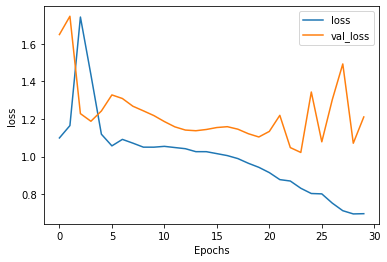

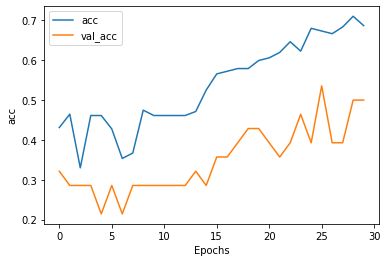

accuracy: 0.05357142857142857
RMSE: 0.947310944441142
Macro averaged F1 socre: 0.09103958564557897


In [ ]:
plot_graphs(history, 'loss')  ################# 2 Bilstm + attention
plot_graphs(history, 'acc')

_loss = myLossHistory.val_loss['epoch'] ##########################

sig_clf_probs = model.predict(X_te_paded) 

y_hat = np.array([np.argmax(i) for i in sig_clf_probs]) ######################### predicted label as 3 classes

clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

for i in range(len(y_hat)):
  if y_hat[i]!=0:
    clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
  else:
    if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
      clf_confidence[i] = sig_clf_probs[i][1]
      y_hat[i] = 1
    else:
      clf_confidence[i] = sig_clf_probs[i][2]
      y_hat[i] = 2

score,rmse,macroF = scorer(Y_te,y_hat,clf_confidence) # F-score is ill-defined and being set to 0.0 in labels with no predicted samples
print('accuracy:', score)
print('RMSE:', rmse)
print('Macro averaged F1 socre:', macroF)

In [ ]:
import time
time.sleep(2000)

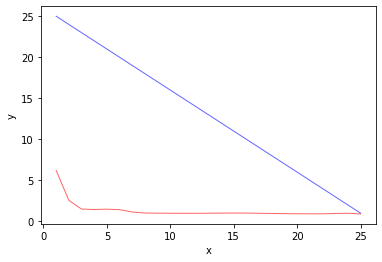

In [ ]:
import matplotlib.pyplot as plot

#分别存放所有点的横坐标和纵坐标，一一对应
x_list = list(range(1,26))
y_list = bilstm_loss

x = x_list
y = t

#创建图并命名
plt.figure('Line fig')
ax = plt.gca()
#设置x轴、y轴名称
ax.set_xlabel('x')
ax.set_ylabel('y')

#画连线图，以x_list中的值为横坐标，以y_list中的值为纵坐标
#参数c指定连线的颜色，linewidth指定连线宽度，alpha指定连线的透明度
ax.plot(x_list, y_list, color='r', linewidth=1, alpha=0.6)
ax.plot(x, y, color='b', linewidth=1, alpha=0.6)

plt.show()